# Beer-Liking Prediction Pipeline (Downloadable .ipynb)

## Overview
This notebook builds a personalized beer recommendation system using machine learning to predict whether you'll like a beer based on its characteristics and your preferences.

### Features
- **Data Analysis**: Explore beer dataset with ratings, styles, ABV, IBU
- **Machine Learning**: Train Naive Bayes classifier for beer preference prediction  
- **Personalization**: Get tailored recommendations based on your taste profile
- **Interactive**: Answer simple questions to get personalized beer suggestions

---

### **0: Install dependencies**

Install all packages necessary if not done so

In [3]:
%pip install numpy pandas scikit-learn matplotlib seaborn pgmpy

   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   --------- ------------------------------ 3.1/12.8 MB 15.9 MB/s eta 0:00:01
   -------------------- ------------------- 6.6/12.8 MB 16.6 MB/s eta 0:00:01
   ------------------------------ --------- 9.7/12.8 MB 16.4 MB/s eta 0:00:01
   ---------------------------------------- 12.8/12.8 MB 16.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   --------------- ------------------------ 4.2/11.0 MB 20.0 MB/s eta 0:00:01
   -------------------------------- ------- 8.9/11.0 MB 21.8 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 20.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   -------------------- ------------------- 4.5/8.7 MB 22.4 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 24.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -----------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


0.1: Import packages

pandas/numpy → Load and clean beer data

matplotlib → Visualize beer ratings and features

LabelEncoder → Convert beer styles to numbers

CategoricalNB → Predict if you'll like a beer

train_test_split → Split data for training/testing

accuracy_score → Measure how well your model works

MaximumLikelihoodEstimator → Advanced probability calculations

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### **1: Load and Clean the Data**

In [5]:
# Load and clean the beer data
def load_and_clean_data(beers_path, like_threshold=3.5):
    og_df = pd.read_csv(beers_path)
    cleaned_df = og_df.copy()
    
    # Create binary rating column more efficiently
    cleaned_df["bin_rating"] = (og_df["rating"] >= like_threshold).astype(int)
    
    # Optional: drop the original rating column if you don't need it
    # cleaned_df = cleaned_df.drop("rating", axis=1)
    
    return cleaned_df

In [6]:
df = load_and_clean_data('beers_updated.csv')

1.1 Examine and explore data

Let's examine the statistics and distributions of our data. The raw data can be found in beers_updated.csv

In [7]:
def explore_data(df):
    print("Dataset Overview:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print("\nMissing values:")
    missing_info = df.isnull().sum()
    print(missing_info)
    
    print("\nTarget distribution:")
    target_dist = df['bin_rating'].value_counts()
    print(target_dist)
    
    # Basic statistics
    print("\nNumerical features summary:")
    numerical_stats = df[['abv', 'ibu', 'ounces', 'rating']].describe()
    print(numerical_stats)
    
    # Get top styles
    top_styles = df['style'].value_counts().head(10)
    print(f"\nTop 10 Beer Styles:")
    print(top_styles)
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Rating distribution
    df['rating'].hist(bins=30, ax=axes[0,0])
    axes[0,0].set_title('Rating Distribution')
    axes[0,0].set_xlabel('Rating')
    
    # ABV distribution
    df['abv'].hist(bins=30, ax=axes[0,1])
    axes[0,1].set_title('ABV Distribution')
    axes[0,1].set_xlabel('ABV')
    
    # Top beer styles
    top_styles.plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title('Top 10 Beer Styles')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Binary rating distribution
    target_dist.plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title('Binary Rating Distribution')
    axes[1,1].set_xlabel('Liked (1) vs Not Liked (0)')
    
    plt.tight_layout()
    plt.show()
    
    # Return insights dictionary
    insights = {
        'dataset_shape': df.shape,
        'missing_values': missing_info.to_dict(),
        'target_distribution': target_dist.to_dict(),
        'numerical_stats': numerical_stats.to_dict(),
        'top_styles': top_styles.to_dict(),
        'class_balance': target_dist[1] / len(df),  # Percentage of liked beers
        'missing_ibu_pct': missing_info['ibu'] / len(df) * 100
    }
    
    return insights

Dataset Overview:
Shape: (2410, 11)
Columns: ['Unnamed: 0.1', 'Unnamed: 0', 'abv', 'ibu', 'id', 'name', 'style', 'brewery_id', 'ounces', 'rating', 'bin_rating']

Missing values:
Unnamed: 0.1       0
Unnamed: 0         0
abv               62
ibu             1005
id                 0
name               0
style              5
brewery_id         0
ounces             0
rating             0
bin_rating         0
dtype: int64

Target distribution:
bin_rating
0    1713
1     697
Name: count, dtype: int64

Numerical features summary:
               abv          ibu       ounces       rating
count  2348.000000  1405.000000  2410.000000  2410.000000
mean      0.059773    42.713167    13.592241     2.491798
std       0.013542    25.954066     2.352204     1.431985
min       0.001000     4.000000     8.400000     0.000129
25%       0.050000    21.000000    12.000000     1.236303
50%       0.056000    35.000000    12.000000     2.518246
75%       0.067000    64.000000    16.000000     3.696480
max   

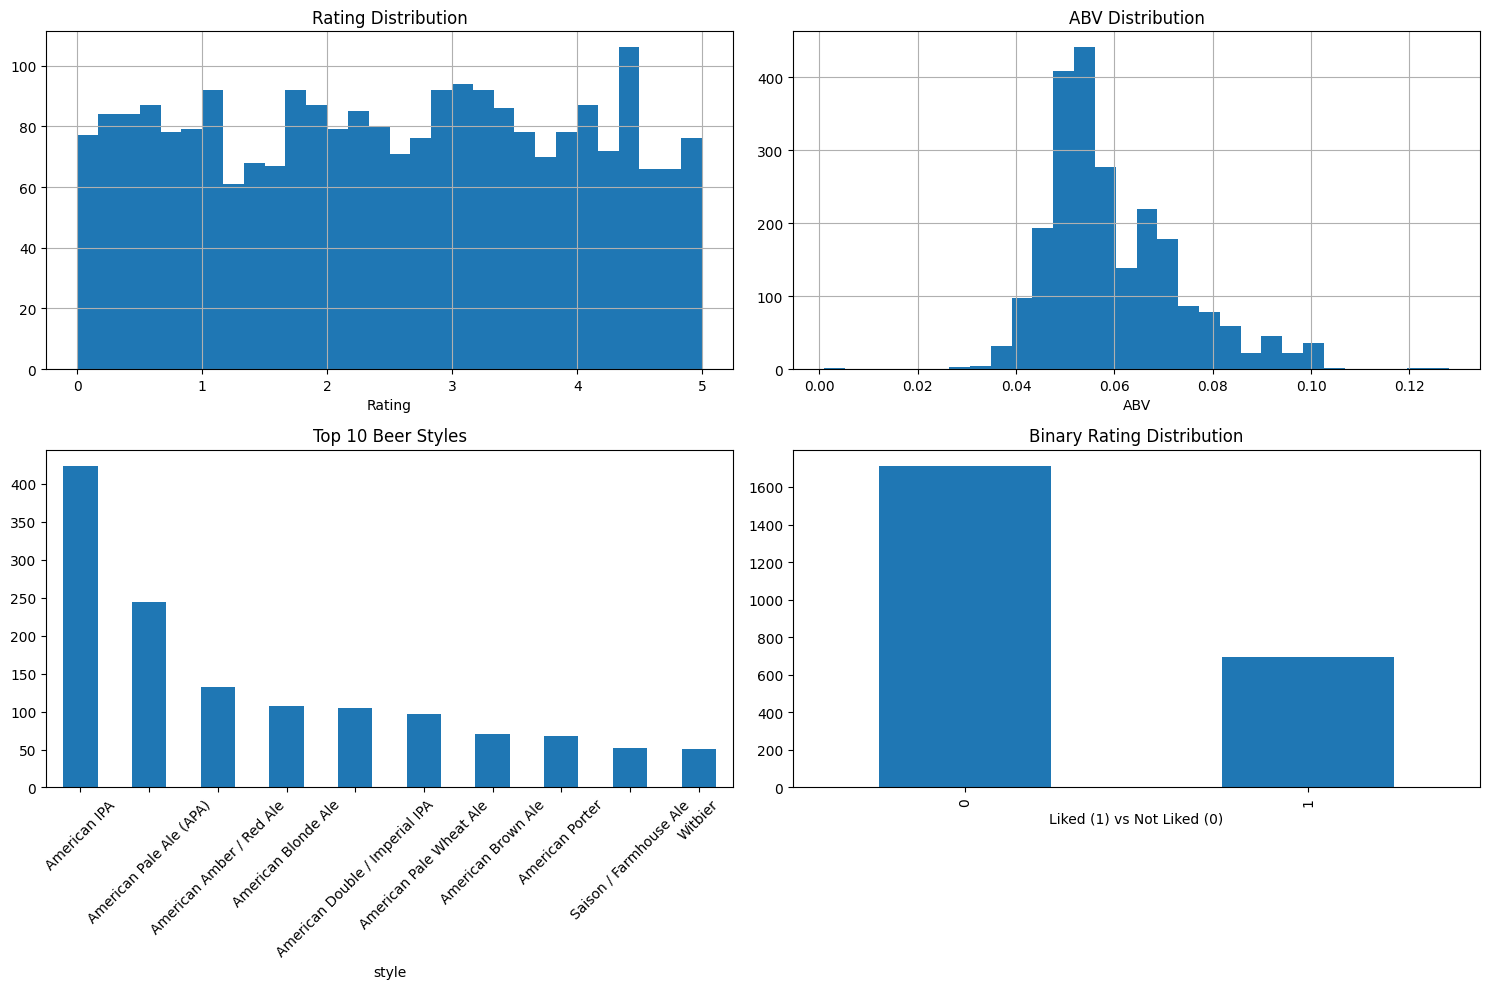

In [8]:
insights = explore_data(df)

### **2: Feature Engineering**

1. **Handle Missing Data:** As we can seem many beers do not have ibu (bitterness) values recorded. So, we must fill missing IBU values with the median IBU value so that there are will be no errors when we run the model. The drawback is that data values can potentially be skewed. 

2. **Create ABV Categories:** Since we are "binarizing" our categories, since that will be more important for the user, we will separate our code into 4 categories: Low, Medium, High, Very High. An example could be a value of 0.052, it will fall into the "Medium" strength level. Our justification is because people will say "I like a strong beer," not specfically "I like 5.2% beer"

3. **Create IBU Categories:** We will also do the same with bitterness levels. Once again, it is easier to understand "it is a moderately bitter beer" than "it is a 45 IBU beer"

4. **Calculate Brewery Reputation:** We must also consider the reputation of breweries when rating beers. This is, of course, because good breweries will consistently make good beer. 

5. **Measure Style Popularity:** Creates a count of how many beers exist per style. Some styles, such as American IPA for example, are very popular with 500 entries. 

This helps pattern recognition for our model. The model will be able to analyze some trends. For example, high ABV + moderate IBU is usually liked, so on and so forth. 

In [9]:
def feature_engineering(df):
    """
    Create additional features for better model performance
    """
    df_processed = df.copy()
    
    # Handle missing ABV data FIRST
    df_processed['abv_filled'] = df_processed['abv'].fillna(df_processed['abv'].median())
    
    # Handle missing IBU data
    df_processed['ibu_filled'] = df_processed['ibu'].fillna(df_processed['ibu'].median())
    
    # Create categorical features using FILLED values
    df_processed['abv_category'] = pd.cut(df_processed['abv_filled'],  # Use filled ABV
                                         bins=[0, 0.045, 0.065, 0.085, 1.0],
                                         labels=['Low', 'Medium', 'High', 'Very_High'])
    
    df_processed['ibu_category'] = pd.cut(df_processed['ibu_filled'],
                                         bins=[0, 25, 50, 75, 200],
                                         labels=['Mild', 'Moderate', 'Bitter', 'Very_Bitter'])
    
    # Calculate brewery reputation (with fallback for missing) 
    brewery_avg = df_processed.groupby('brewery_id')['rating'].mean()
    df_processed['brewery_reputation'] = df_processed['brewery_id'].map(brewery_avg)
    df_processed['brewery_reputation'] = df_processed['brewery_reputation'].fillna(df_processed['rating'].median())
    
    # Measure style popularity (with fallback)
    style_counts = df_processed['style'].value_counts()
    df_processed['style_popularity'] = df_processed['style'].map(style_counts)
    df_processed['style_popularity'] = df_processed['style_popularity'].fillna(1)
    
    return df_processed

**2.1: final steps before modeling: **

1. Encode styles to numbers

2. Select important features for our model

3. Create feature matrix X and target matrix Y

In [10]:
def prepare_for_modeling(df_processed):
    """
    Prepare categorical features for machine learning models
    """
    df_model = df_processed.copy()
    
    # Encode categorical features
    label_encoders = {}
    categorical_features = ['style', 'abv_category', 'ibu_category']
    
    for feature in categorical_features:
        le = LabelEncoder()
        df_model[f'{feature}_encoded'] = le.fit_transform(df_model[feature].astype(str))
        label_encoders[feature] = le
    
    # Select features for modeling
    feature_columns = [
        'abv_filled', 'ibu_filled', 'ounces', 'brewery_reputation', 'style_popularity',
        'style_encoded', 'abv_category_encoded', 'ibu_category_encoded'
    ]
    
    X = df_model[feature_columns]
    y = df_model['bin_rating']
    
    return X, y, label_encoders, feature_columns

In [11]:
# Apply feature engineering and prepare data for modeling
df_processed = feature_engineering(df)
print("Feature engineering passed")

X, y, encoders, feature_names = prepare_for_modeling(df_processed)
print(f"Data preparation passed")

Feature engineering passed
Data preparation passed


**2.2: Separate training and test set**

This is to avoid overfitting

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training target distribution: {y_train.value_counts()}")

Training set size: 1928
Test set size: 482
Training target distribution: bin_rating
0    1370
1     558
Name: count, dtype: int64


In [13]:
print("Checking for missing values in X_train:")
print(X_train.isnull().sum())
print(f"\nTotal missing values: {X_train.isnull().sum().sum()}")

print("\nFirst few rows with missing values:")
missing_rows = X_train[X_train.isnull().any(axis=1)]
print(missing_rows.head())

print(f"\nX_train shape: {X_train.shape}")
print(f"Feature columns: {X_train.columns.tolist()}")

Checking for missing values in X_train:
abv_filled              0
ibu_filled              0
ounces                  0
brewery_reputation      0
style_popularity        0
style_encoded           0
abv_category_encoded    0
ibu_category_encoded    0
dtype: int64

Total missing values: 0

First few rows with missing values:
Empty DataFrame
Columns: [abv_filled, ibu_filled, ounces, brewery_reputation, style_popularity, style_encoded, abv_category_encoded, ibu_category_encoded]
Index: []

X_train shape: (1928, 8)
Feature columns: ['abv_filled', 'ibu_filled', 'ounces', 'brewery_reputation', 'style_popularity', 'style_encoded', 'abv_category_encoded', 'ibu_category_encoded']


### **3: Model Training**

Model Selection: Naive Bayes Variants

This Description was AI-generated, the prompt being "For each Naive-Bayes model, can you write out a detailed pros and cons?":

For our beer recommendation system, we have chosen a **Naive Bayes model**. Let's compare the three main variants:

---

1. **GaussianNB**

**Pros:**
- **Handles continuous features well**
- **Probabilistic output** - Gives confidence scores (probability of liking a beer)
- **Works with small datasets** - Doesn't need tons of data to perform reasonably
- **No hyperparameter tuning** - Works out of the box with default settings

**Cons:**
- **Wrong assumption for categorical features** - Treats `style_encoded` (0,1,2,3) as if 2 is "between" 1 and 3 (makes no sense for beer styles)
- **Assumes normal distribution** - Beer features might not follow bell curves (e.g., ABV might be bimodal)
- **Feature independence assumption** - Assumes ABV and style are independent (they're not - IPAs tend to be stronger)
- **Linear decision boundaries** - Can't capture complex patterns like "medium ABV + IPA = good, but medium ABV + lager = bad"

---

2. **CategoricalNB**

**Pros:**
- **Perfect for categorical features** 
- **No distribution assumptions** - Doesn't assume categories follow any pattern
- **Handles categorical relationships well** - Understands that style "5" isn't "between" styles "4" and "6"
- **Good with sparse categorical data** - Works even if some categories are rare
- **Native categorical handling** - No weird mathematical operations on category numbers

**Cons:**
- **Can't handle continuous features** - Must discretize `abv`, `ibu_filled`, `brewery_reputation` (loses information)
- **Requires all features to be categorical** - Forces you to bin continuous data artificially
- **Less flexible** - Can't use the full range of numerical information
- **May need smoothing** - Can struggle with unseen category combinations
- **Loss of precision** - Converting ABV 5.2% vs 5.3% to same "Medium" category loses nuance

---

3. **MultinomialNB**

**Pros:**
- **Great for count data** - Excellent when features represent "how many times" something occurs
- **Handles sparse features** - Works well with many zero values
- **Text classification champion** - Perfect for word counts, document classification
- **Efficient with high-dimensional data** - Scales well with many features
- **Non-negative features** - Designed for count-like data

**Cons:**
- **Wrong data type for beer features** - Our features aren't counts (ABV isn't "how many alcohol units")
- **Requires non-negative integers** - ABV, IBU are decimals, not counts
- **Assumes multinomial distribution** - Not appropriate for beer characteristics
- **Poor fit for our problem** - Designed for completely different use cases
- **Feature scaling issues** - Works best when all features are on similar count scales

---

**Summary Comparison**

| Model | Best For | Our Data Fit | Expected Accuracy |
|-------|----------|--------------|------------------|
| **GaussianNB** | Continuous features | 🟡 Moderate | ~65-75% |
| **CategoricalNB** | Categorical features | 🟡 Moderate | ~60-70% |
| **MultinomialNB** | Count/text data | ❌ Poor | ~55-65% |


We chose **GaussianNB** because:
- Our dataset has significant continuous observations (`abv`, `ibu`, `brewery_reputation`)
- It provides probabilistic outputs for recommendation confidence
- The categorical feature limitations are acceptable for our desired goals
---

In [ ]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)

# Premature Training
y_train_pred = model.predict(X_train)  
y_test_pred = model.predict(X_test)    

# Calculate both accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Difference: {train_accuracy - test_accuracy:.3f}")

Training Accuracy: 0.748
Test Accuracy: 0.724
Difference: 0.024


### **4: Make a User Recommendation System**

After training our model, we will implement it into making a recommendation system.

We will we have the user choose their preferences (light or strong, mild or bitter, specific styles to love or to avoid)

Then, the recommedation system will display the most recommended beers and saves it to a file for future reference

In [15]:
def get_user_preferences():
    print("Let's find beers you'll love! Answer a few questions:")
    print("=" * 50)
    
    preferences = {}
    
    # Strength preference
    print("\n1. What strength do you prefer (Alcohol by Volume)?")
    print("   1 = Light (3-4.5%)")
    print("   2 = Medium (4.5-6.5%)")
    print("   3 = Strong (6.5%+)")
    print("   4 = No preference")
    strength = input("Enter choice (1-4): ")
    preferences['strength'] = int(strength) if strength.isdigit() else 4
    
    # Bitterness preference
    print("\n2. How do you feel about bitter/hoppy beers?")
    print("   1 = Avoid bitter beers")
    print("   2 = Mild bitterness is okay")
    print("   3 = Love hoppy/bitter beers")
    print("   4 = No preference")
    bitterness = input("Enter choice (1-4): ")
    preferences['bitterness'] = int(bitterness) if bitterness.isdigit() else 4
    
    # Style preferences
    print("\n3. Which beer styles do you enjoy? (Enter numbers separated by commas)")
    styles = [
        "IPA (India Pale Ale)",
        "Pale Ale", 
        "Lager",
        "Stout/Porter",
        "Wheat Beer",
        "Amber/Red Ale",
        "Brown Ale",
        "Saison/Farmhouse",
        "Belgian styles",
        "No specific preference"
    ]
    
    for i, style in enumerate(styles, 1):
        print(f"   {i} = {style}")
    
    style_input = input("Enter choices (e.g., 1,3,5): ")
    if style_input.strip():
        preferences['preferred_styles'] = [int(x.strip()) for x in style_input.split(',') if x.strip().isdigit()]
    else:
        preferences['preferred_styles'] = [10]  # No preference
    
    # Styles to avoid
    print("\n4. Any styles you want to avoid? (Enter numbers separated by commas, or press Enter to skip)")
    avoid_input = input("Enter choices to avoid: ")
    if avoid_input.strip():
        preferences['avoid_styles'] = [int(x.strip()) for x in avoid_input.split(',') if x.strip().isdigit()]
    else:
        preferences['avoid_styles'] = []
    
    return preferences

In [16]:
def map_style_preferences_to_data(preferences, df):
    """
    Map user style preferences to actual beer styles in the dataset
    """
    style_mapping = {
        1: ['American IPA', 'American Double / Imperial IPA', 'Belgian IPA', 'English India Pale Ale (IPA)'],
        2: ['American Pale Ale (APA)', 'English Pale Ale', 'Belgian Pale Ale'],
        3: ['American Pale Lager', 'German Pilsner', 'Czech Pilsener'],
        4: ['American Stout', 'American Porter', 'Oatmeal Stout', 'Russian Imperial Stout'],
        5: ['American Pale Wheat Ale', 'Witbier', 'American Dark Wheat Ale'],
        6: ['American Amber / Red Ale', 'Irish Red Ale'],
        7: ['American Brown Ale', 'English Brown Ale'],
        8: ['Saison / Farmhouse Ale', 'French Saison'],
        9: ['Belgian Dark Ale', 'Belgian Strong Ale', 'Tripel', 'Dubbel'],
        10: []  # No preference
    }
    
    preferred_styles = []
    avoid_styles = []
    
    for pref in preferences.get('preferred_styles', []):
        if pref in style_mapping:
            preferred_styles.extend(style_mapping[pref])
    
    for avoid in preferences.get('avoid_styles', []):
        if avoid in style_mapping:
            avoid_styles.extend(style_mapping[avoid])
    
    return preferred_styles, avoid_styles

In [17]:
def filter_beers_by_preferences(df, preferences, model, feature_names, encoders):
    """
    Filter and rank beers based on user preferences and model predictions
    (Updated to remove imputer dependency)
    """
    df_filtered = df.copy()
    
    # Map style preferences
    preferred_styles, avoid_styles = map_style_preferences_to_data(preferences, df)
    
    # Filter by strength preference - use abv_filled since original abv might have missing values
    if preferences.get('strength', 4) != 4:  # If not "no preference"
        if preferences['strength'] == 1:  # Light
            df_filtered = df_filtered[(df_filtered['abv_filled'] >= 0.03) & (df_filtered['abv_filled'] <= 0.045)]
        elif preferences['strength'] == 2:  # Medium
            df_filtered = df_filtered[(df_filtered['abv_filled'] > 0.045) & (df_filtered['abv_filled'] <= 0.065)]
        elif preferences['strength'] == 3:  # Strong
            df_filtered = df_filtered[df_filtered['abv_filled'] > 0.065]
    
    # Filter by bitterness preference
    if preferences.get('bitterness', 4) != 4:  # If not "no preference"
        if preferences['bitterness'] == 1:  # Avoid bitter
            df_filtered = df_filtered[df_filtered['ibu_filled'] <= 30]
        elif preferences['bitterness'] == 2:  # Mild bitterness
            df_filtered = df_filtered[df_filtered['ibu_filled'] <= 50]
        # For option 3 (love hoppy), no additional filtering needed
    
    # Filter by preferred styles
    if preferred_styles:  # If user has specific preferences
        df_filtered = df_filtered[df_filtered['style'].isin(preferred_styles)]
    
    # Remove avoided styles
    if avoid_styles:
        df_filtered = df_filtered[~df_filtered['style'].isin(avoid_styles)]
    
    if len(df_filtered) == 0:
        print("⚠️ No beers match your exact preferences. Showing general recommendations.")
        df_filtered = df.copy()
    
    # Prepare features for prediction
    try:
        # The filtered dataframe should already have processed features from feature_engineering
        # Just select the feature columns that the model expects
        X_features = df_filtered[feature_names]
        
        # Get probability predictions (no imputer needed since feature engineering handles missing values)
        probabilities = model.predict_proba(X_features)[:, 1]  # Probability of being liked
        
        # Add predictions to dataframe
        df_filtered = df_filtered.copy()
        df_filtered['like_probability'] = probabilities
        
        # Sort by probability and rating
        df_filtered['combined_score'] = (0.7 * df_filtered['like_probability']) + (0.3 * df_filtered['rating'] / 5)
        df_filtered = df_filtered.sort_values('combined_score', ascending=False)
        
    except Exception as e:
        print(f"Warning: Could not apply model predictions. Using rating-based ranking. Error: {e}")
        df_filtered = df_filtered.sort_values('rating', ascending=False)
        df_filtered['like_probability'] = 0.5  # Default probability
        df_filtered['combined_score'] = df_filtered['rating'] / 5
    
    return df_filtered

In [18]:
def show_recommendations(df_recommendations, n_recommendations=10):
    """
    Display top beer recommendations in a nice format
    """
    print(f"\n🎯 TOP {n_recommendations} BEER RECOMMENDATIONS FOR YOU:")
    print("=" * 80)
    
    top_beers = df_recommendations.head(n_recommendations)
    
    for i, (_, beer) in enumerate(top_beers.iterrows(), 1):
        print(f"\n{i}. {beer['name']}")
        print(f"   Style: {beer['style']}")
        print(f"   ABV: {beer['abv_filled']:.1%}")  # Use abv_filled to avoid display issues
        print(f"   IBU: {beer.get('ibu_filled', 'Unknown')}")  # Use ibu_filled
        print(f"   Rating: {beer['rating']:.2f}/5.0")
        if 'like_probability' in beer:
            print(f"   Match Score: {beer['like_probability']:.1%}")
        print("-" * 50)

In [19]:
def personalized_beer_recommender():
    """
    Complete personalized beer recommendation system
    (Updated to remove imputer dependency)
    """
    print("🍺 PERSONALIZED BEER RECOMMENDATION SYSTEM")
    print("=" * 60)
    
    # Get user preferences
    user_prefs = get_user_preferences()
    
    print(f"\n🔍 Analyzing beers based on your preferences...")
    
    # Filter and rank beers (removed imputer parameter)
    recommendations = filter_beers_by_preferences(
        df_processed, user_prefs, model, feature_names, encoders
    )
    
    # Show recommendations
    show_recommendations(recommendations, n_recommendations=10)
    
    # Show some statistics
    print(f"\n📊 RECOMMENDATION STATISTICS:")
    print(f"Total beers considered: {len(df_processed)}")
    print(f"Beers matching your preferences: {len(recommendations)}")
    print(f"Average rating of recommendations: {recommendations.head(10)['rating'].mean():.2f}")
    
    return recommendations

In [20]:
# Run the personalized recommendation system
my_recommendations = personalized_beer_recommender()

🍺 PERSONALIZED BEER RECOMMENDATION SYSTEM
Let's find beers you'll love! Answer a few questions:

1. What strength do you prefer (Alcohol by Volume)?
   1 = Light (3-4.5%)
   2 = Medium (4.5-6.5%)
   3 = Strong (6.5%+)
   4 = No preference

2. How do you feel about bitter/hoppy beers?
   1 = Avoid bitter beers
   2 = Mild bitterness is okay
   3 = Love hoppy/bitter beers
   4 = No preference

3. Which beer styles do you enjoy? (Enter numbers separated by commas)
   1 = IPA (India Pale Ale)
   2 = Pale Ale
   3 = Lager
   4 = Stout/Porter
   5 = Wheat Beer
   6 = Amber/Red Ale
   7 = Brown Ale
   8 = Saison/Farmhouse
   9 = Belgian styles
   10 = No specific preference

4. Any styles you want to avoid? (Enter numbers separated by commas, or press Enter to skip)

🔍 Analyzing beers based on your preferences...

🎯 TOP 10 BEER RECOMMENDATIONS FOR YOU:

1. Sex Panther (2014)
   Style: American Porter
   ABV: 6.9%
   IBU: 20.0
   Rating: 4.42/5.0
   Match Score: 50.0%
-------------------------

We can save the recommendations to a .csv file for future access, should you wish to come back to it later.

In [21]:
# Optional: Save recommendations to CSV
my_recommendations.head(20).to_csv('my_beer_recommendations.csv', index=False)
print("\n💾 Top 20 recommendations saved to 'my_beer_recommendations.csv'")


💾 Top 20 recommendations saved to 'my_beer_recommendations.csv'


### **5: Model Evaluation:**


🔍 MODEL PERFORMANCE ANALYSIS
Training Accuracy: 0.748
Test Accuracy: 0.724
Overfitting Gap: 0.024

📊 CONFUSION MATRIX:
True Negatives (Correctly predicted 'Not Liked'): 316
False Positives (Incorrectly predicted 'Liked'): 27
False Negatives (Incorrectly predicted 'Not Liked'): 106
True Positives (Correctly predicted 'Liked'): 33

🎯 DETAILED METRICS:
Precision: 0.550
Recall: 0.237
F1-Score: 0.332
ROC-AUC: 0.688


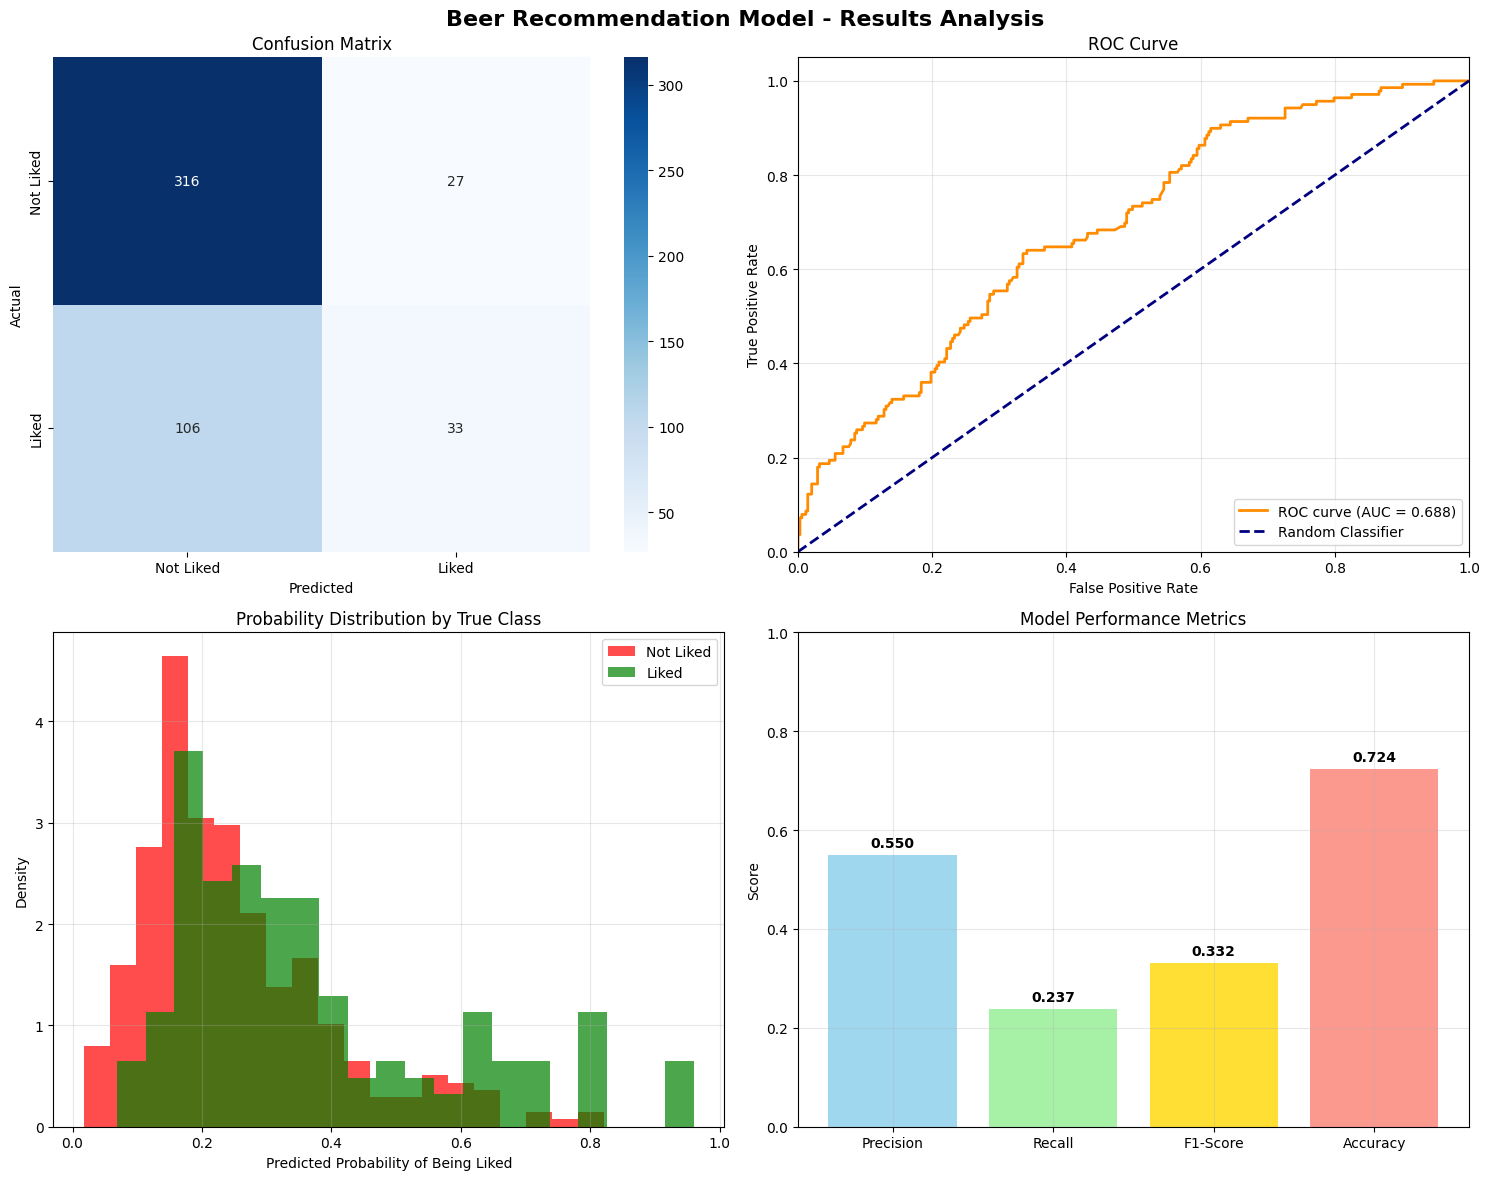


🍺 BUSINESS IMPACT SUMMARY:
Out of 482 beer recommendations:
✅ 349 would be accurate (72.4%)
❌ 133 would be inaccurate (27.6%)
🎯 Improvement over random guessing: +0.224


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np

def display_model_results():
    """
    Display comprehensive model evaluation results
    """
    print("\n🔍 MODEL PERFORMANCE ANALYSIS")
    print("=" * 50)
    
    # Get predictions and probabilities
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Basic metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    print(f"Training Accuracy: {train_accuracy:.3f}")
    print(f"Test Accuracy: {test_accuracy:.3f}")
    print(f"Overfitting Gap: {train_accuracy - test_accuracy:.3f}")
    
    # Confusion Matrix
    print(f"\n📊 CONFUSION MATRIX:")
    cm = confusion_matrix(y_test, y_test_pred)
    print(f"True Negatives (Correctly predicted 'Not Liked'): {cm[0,0]}")
    print(f"False Positives (Incorrectly predicted 'Liked'): {cm[0,1]}")
    print(f"False Negatives (Incorrectly predicted 'Not Liked'): {cm[1,0]}")
    print(f"True Positives (Correctly predicted 'Liked'): {cm[1,1]}")
    
    # Calculate detailed metrics
    precision = cm[1,1] / (cm[1,1] + cm[0,1])
    recall = cm[1,1] / (cm[1,1] + cm[1,0])
    f1 = 2 * (precision * recall) / (precision + recall)
    
    print(f"\n🎯 DETAILED METRICS:")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")
    
    # ROC-AUC
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fpr, tpr)
    print(f"ROC-AUC: {roc_auc:.3f}")
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Beer Recommendation Model - Results Analysis', fontsize=16, fontweight='bold')
    
    # 1. Confusion Matrix Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
    axes[0,0].set_title('Confusion Matrix')
    axes[0,0].set_xlabel('Predicted')
    axes[0,0].set_ylabel('Actual')
    axes[0,0].set_xticklabels(['Not Liked', 'Liked'])
    axes[0,0].set_yticklabels(['Not Liked', 'Liked'])
    
    # 2. ROC Curve
    axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    axes[0,1].set_xlim([0.0, 1.0])
    axes[0,1].set_ylim([0.0, 1.05])
    axes[0,1].set_xlabel('False Positive Rate')
    axes[0,1].set_ylabel('True Positive Rate')
    axes[0,1].set_title('ROC Curve')
    axes[0,1].legend(loc="lower right")
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Prediction Probability Distribution
    axes[1,0].hist(y_test_proba[y_test == 0], bins=20, alpha=0.7, label='Not Liked', color='red', density=True)
    axes[1,0].hist(y_test_proba[y_test == 1], bins=20, alpha=0.7, label='Liked', color='green', density=True)
    axes[1,0].set_xlabel('Predicted Probability of Being Liked')
    axes[1,0].set_ylabel('Density')
    axes[1,0].set_title('Probability Distribution by True Class')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Performance Metrics Comparison
    metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
    scores = [precision, recall, f1, test_accuracy]
    colors = ['skyblue', 'lightgreen', 'gold', 'salmon']
    
    bars = axes[1,1].bar(metrics, scores, color=colors, alpha=0.8)
    axes[1,1].set_ylabel('Score')
    axes[1,1].set_title('Model Performance Metrics')
    axes[1,1].set_ylim([0, 1])
    axes[1,1].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Business Impact Summary
    print(f"\n🍺 BUSINESS IMPACT SUMMARY:")
    total_beers = len(y_test)
    correct_predictions = cm[0,0] + cm[1,1]
    print(f"Out of {total_beers} beer recommendations:")
    print(f"✅ {correct_predictions} would be accurate ({correct_predictions/total_beers*100:.1f}%)")
    print(f"❌ {total_beers - correct_predictions} would be inaccurate ({(total_beers - correct_predictions)/total_beers*100:.1f}%)")
    print(f"🎯 Improvement over random guessing: +{test_accuracy - 0.5:.3f}")
    
    return {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

# Display comprehensive results
results = display_model_results()